```{index} single: Pyomo; block
```
```{index} single: Pyomo; kernel library
```
```{index} single: application; support vector machines
```
```{index} single: application; binary classification
```
```{index} single: application; counterfeit banknotes
```
# Support Vector Machines for Binary Classification

Support Vector Machines (SVM) are supervised machine learning models. This notebook shows how to implement an SVM  for binary classification using linear and conic programming. The first implementation produces linear support vector machines that separates the "feature space" with a hyperplane. This is demonstrated for both primal and dual formulations. The dual formulation extends naturally to binary classification in high order feature spaces.

Like other machine learning techniques based on regression, an SVM classifier can be implemented as the solution to an optimization problem. The optimization problem runs once using training samples with known outcomes to produce parameters for a classifier. The resulting classifier can then be use to classify data with unknown outcomes.


In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_mosek()

pyomo was previously installed
mosek was previously installed


## Binary Classification

Binary classifiers are functions designed to answer questions such as "does this medical test indicate disease?", "will this specific customer enjoy that specific movie?", "does this photo include a car?", or "is this banknote genuine or counterfeit?" These questions are answered based on the values of "features", which may include physical measurements or other types of data collected from a representative sample with known outcomes.

For example, consider a device installed in a vending machine to detect banknotes. The classifier's goal is to accurately identify and accept genuine banknotes while rejecting counterfeit ones. The classifier's performance can be assessed using definitions in following table, where "positive" refers to an instance of a genuine banknote.

| | Predicted Positive  | Predicted Negative | |
| :-- | :--: | :--: | :-- |
| Actual Positive | True Positive (TP) | False Negative (FN) |
| Actual Negative | False Positive (FP) | True Negative (TN) |

A vending machine user would be frustrated if a genuine banknote is incorrectly rejected as a false negative. **Sensitivity** is defined as the number of true positives (TP) divided by the total number of actual positives (TP + FN). A high sensitivity means almost all genuine banknotes are accepted making it the preferred outcome for users.

The vending machine owner, on the other hand, wants the machine to avoid accepting counterfeit banknotes and would therefore prefer a low number of false positives (FP). **Precision** is the number of true positives (TP) divided by the total number of predicted positives (TP + FP). A high precision implies almost all of the accepted notes are genuine, making it the preferred outcome for the owner.

* **Sensitivity**: The number of true positives divided by the total number of actual positives. High sensitivity indicates a low false negative rate.

* **Precision**: The number of true positives identified by the model divided by the total number of predicted positives, which includes both true and false positives. High precision indicates a low false positive rate.

To achieve high sensitivity, a classifier can follow the "innocent until proven guilty" standard, rejecting banknotes only when certain they are counterfeit. To achieve high precision, a classifier can adopt the "guilty unless proven innocent" standard, rejecting banknotes unless absolutely certain they are genuine. The challenge in developing binary classifiers is to balance these conflicting objectives and to optimize performance from both perspectives simultaneously.

## The Data Set 

The following data set contains data from a collection of known genuine and known counterfeit banknote specimens. The data includes four continuous statistical measures obtained from the wavelet transform of banknote images named "variance", "skewness", "curtosis", and "entropy", and a binary variable named "class" which is 0 if genuine and 1 if counterfeit.

https://archive.ics.uci.edu/ml/datasets/banknote+authentication

### Read data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# read data set
df = pd.read_csv("data_banknote_authentication.txt", header=None)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]
df.name = "Banknotes"

# show a few rows
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
# get a statistical description of the data set
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Select features and training sets

Following customary practices, we divide the data set into a **training set** used to trail the classifier, and a **testing set** that will be used to evaluate the performance of the classifier. In addition, we select two dimensional subset of the features to enable plotting of the results for exposition. Since our definition of a positive outcome corresponds to detecting a genuine banknote, we rescale the "class" feature to have values of 1 for genuine banknotes and -1 for counterfeit banknotes. 

Text(0.5, 1.0, 'Banknote Training Set')

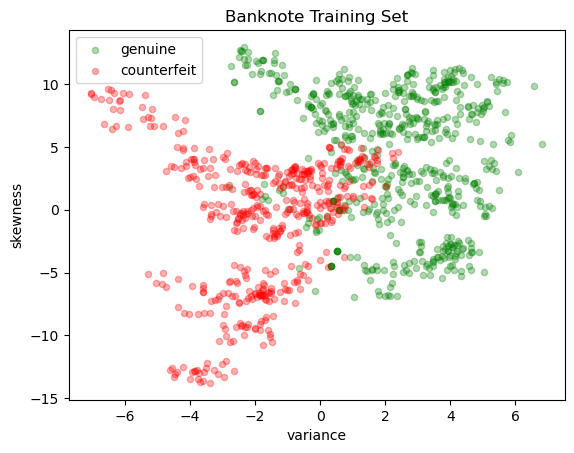

In [4]:
# create training and validation test sets
df_train, df_test = train_test_split(df, test_size=0.2)

# select training features
features = ["variance", "skewness"]

# separate into features and outputs
X_train = df_train[features]
y_train = 1 - 2 * df_train["class"]

# separate into features and outputs
X_test = df_test[features]
y_test = 1 - 2 * df_test["class"]

# plot the training set
fig, ax = plt.subplots()

kwargs = {"x": "variance", "y": "skewness", "kind": "scatter", "ax": ax, "alpha": 0.3}

# catch and ignore warnings from matplotlib scatter plot
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X_train[y_train > 0].plot(**kwargs, c="g", label="genuine")
    X_train[y_train < 0].plot(**kwargs, c="r", label="counterfeit")
ax.set_title("Banknote Training Set")

## Support vector machines (SVM)

### Linear SVM classifier

A linear support vector machine (SVM) is a binary classification method that employs a linear equation to determine the class assignment. The basic  formula is expressed as:

$$y^{pred} = \text{sgn}\ ( w^\top x + b)$$

where $x$ is a point $x\in\mathbb{R}^p$ in "feature" space. Here $w\in \mathbb{R}^p$ represents a set of coefficients, $w^\top x$ is the dot product, and $b$ is a scalar coefficient.  The linear function divides the feature space using the hyperplane defined by $w$ and $b$. Points on one side of the hyperplane are assigned a positive outcome (+1), while points on the other side are assigned a negative outcome (-1).

The following code cell contains a Python implementation of a linear SVM. An instance of `LinearSVM` is defined with a coefficient vector $w$ and a scalar $b$. In this implementation, all data and parameters are provided as Pandas Series or DataFrame objects, and use the Pandas `.dot()` function is used to compute the necessary dot product.

In [5]:
import pandas as pd
import numpy as np

class LinearSvm():
    
    def __init__(self, w, b):
        self.w = pd.Series(w)
        self.b = b
        
    def predict(self, X):
        return np.sign(X.dot(self.w) + self.b)

A visual inspection of training set for the banknote, shown above, shows the two dimensional feature set can be roughly split along the vertical axis where "variance" is zero. Most of the positive outcomes are on the right of the axis, most of the negative outcomes on the left. Since $w$ is a vector normal to this surface, we choose 

$$
\begin{align}
    w & = \begin{bmatrix} w_{variance} \\ w_{skewness} \end{bmatrix} = \begin{bmatrix} 1 \\ 0 \end{bmatrix},
    \qquad b = 0
\end{align}
$$

The code cell below evaluates the accuracy of the linear SVM by calculating the **accuracy score**, which is the fraction of samples that were predicted accurately.

In [6]:
# Visual estimaate of w and b for a linear classifier
w = pd.Series({'variance': 1, 'skewness': 0})
b = 0

# create an instance of LinearSVM
svm_v0 = LinearSvm(w, b)

# predictions for the training set
y_pred = svm_v0.predict(X_test)

# fraction of correct predictions
accuracy = sum(y_pred == y_test) / len(y_test)
print(f"Accuracy = {100 * accuracy: 0.1f}%")

Accuracy =  84.4%


### Performance metrics

The accuracy score alone is not always a reliable metric for evaluating the performance of binary classifiers. For instance, when one outcome is significantly more frequent than the other, a classifier that always predicts the more common outcome without regard to the feature vector can achieve. Moreover, in many applications, the consequences of a false positive can differ from those of a false negative. For these reasons, we seek a more comprehensive set of metrics to compare binary classifiers. A [detailed discussion on this topic](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7) recommends the [Matthews correlation coefficient (MCC)](https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a) as a reliable performance measure for binary classifiers.

The code below demonstrates an example of a function that evaluates the performance of a binary classifier and returns the Matthews correlation coefficient as its output.

In [7]:
def validate(y_true, y_pred, verbose=True):
    """
    This function calculates and displays the sensitivity, precision, and Matthews correlation coefficient (MCC)
    for a binary classifier based on its true labels (y_true) and predicted labels (y_pred).
    
    Args:
    y_true (array-like): A list or array containing the true labels of the samples.
    y_pred (array-like): A list or array containing the predicted labels of the samples.
    verbose (bool, optional): If True, the function prints and displays the calculated metrics and 
                              confusion matrix. Defaults to True.
    
    Returns:
    float: The calculated Matthews correlation coefficient (MCC).
    """

    # Calculate the elements of the confusion matrix
    true_positives = sum((y_true > 0) & (y_pred > 0))
    false_negatives = sum((y_true > 0) & (y_pred < 0))
    false_positives = sum((y_true < 0) & (y_pred > 0))
    true_negatives = sum((y_true < 0) & (y_pred < 0))
    total = true_positives + true_negatives + false_positives + false_negatives

    # Calculate the Matthews correlation coefficient (MCC)
    mcc_numerator = (true_positives * true_negatives) - (false_positives * false_negatives)
    mcc_denominator = np.sqrt((true_positives + false_positives) \
                              * (true_positives + false_negatives) \
                              * (true_negatives + false_positives) \
                              * (true_negatives + false_negatives))
    mcc = mcc_numerator / mcc_denominator

    if verbose:
        print(f"Matthews correlation coefficient (MCC) = {mcc:0.3f}")
        
        # report sensitivity and precision, and accuracy
        sensitivity = true_positives / (true_positives + false_negatives)
        precision = true_positives / (true_positives + false_positives)
        accuracy = (true_positives + true_negatives) / total
        
        print(f"Sensitivity = {100 * sensitivity: 0.1f}%") 
        print(f"Precision = {100 * precision: 0.1f}%") 
        print(f"Accuracy = {100 * accuracy: 0.1f}%")

        # Display the binary confusion matrix
        confusion_matrix = pd.DataFrame(
            [[true_positives, false_negatives], [false_positives, true_negatives]], 
            index = ["Actual Positive", "Actual Negative"], columns=["Predicted Positive", "Predicted Negative"])
        display(confusion_matrix)

    return mcc

y_pred = svm_v0.predict(X_test)
validate(y_test, y_pred);

Matthews correlation coefficient (MCC) = 0.689
Sensitivity =  81.8%
Precision =  87.3%
Accuracy =  84.4%


,Predicted Positive,Predicted Negative
Actual Positive,117,26
Actual Negative,17,115


## Linear optimization model

A training or validation set consists of $n$ observations $(x_i, y_i)$ where $y_i = \pm 1$ and $x_i\in\mathbb{R}^p$ for $i=1, \dots, n$. The training task is to find coefficients $w\in\mathbb{R}^p$ and $b\in\mathbb{R}$ to achieve high sensitivity and high precision for the validation set. All points $(x_i, y_i)$ for $i\in 1, \dots, n$ in a training or validation set are successfully classified if the
 
$$
\begin{align}
    y_i (w^\top x_i + b) & > 0 & \forall i = 1, 2, \dots, n.
\end{align}
$$

As written, this condition imposes no scale for $w$ or $b$ (that is, if the condition is satisfied for any pair $(w, b)$ then it also satisfied for $(\gamma w, \gamma b)$ where $\gamma > 0$). It is convenient, therefore, to impose a modified condition for correctly classified points where

$$
\begin{align*}
y_i (w^\top x_i + b) & \geq 1 & \forall i = 1, 2, \dots, n
\end{align*}
$$

which defines a **hard-margin** classifier. The size of the margin is determined by the scale of $w$ and $b$. In practice, it is not always possible to find $w$ and $b$ that separate all the of data perfectly. The condition for a hard-margin classifier is relaxed by introducing non-negative decision variables $z_i$ where

$$
\begin{align*}
y_i (w^\top x_i + b) & \geq 1 - z_i & \forall i = 1, 2, \dots, n
\end{align*}
$$

The variables $z_i$ measure the degre


An equivalent notation is to rearrange this expression an

For for this purpose, when fitting an SVM to data it is common to use a **soft-margin** classifier. Given parameters $w$ and $b$, the **hinge-loss** function is defined as

$$
\ell(x, y) = \left(1 - y(w^\top x + b)\right)^+,
$$

with the notation $z^+ = \max(0, z)$. By design, for a given $(w, b)$, the hinge-loss function will be zero for any training point correctly classified by the corresponding hard-margin classifier. The hinge-loss function will be less than one for any point correctly classified by $y_i (w^\top x_i + b) > 0$. Otherwise the hinge-loss function is greater than one for any misclassified point, and grows in proportion to how far away the feature vector is from the separation plane. 

These properties make the hinge-loss function useful for training a linear support vector machine. The training problem is formulated as minimizing the hinge-loss function over all the data samples:

$$
\begin{align*}
    \min_{w, b} \frac{1}{n}\sum_{i=1}^n \left(1 - y_i(w^\top x_i + b)\right)^+ .
\end{align*}
$$

Practice has shown that minimizing this term alone produces classifiers with large entries for $w$ which performs poorly on new data samples. For that reason, **regularization** adds a term to penalize the magnitude of $w$. In most formulations a norm $\|w\|$ is used for regularization, commonly a sum of squares such as $\|w\|_2^2$. Another choice is $\|w\|_1$ which, similar to Lasso regression, may result in sparse weighting vector $w$ indicating which elements of the feature vector can be neglected for classification purposes. These considerations result in the objective function

$$
    \min_{w, b}\left[ \lambda \|w\|_1 + \frac{1}{n}\sum_{i=1}^n \left(1 - y_i(w^\top x_i + b)\right)^+ \right]
$$

By introducing $n$ auxiliary non-negative variables $z$'s, the the needed weights are a solution to following LP:

$$
\begin{align*}
\min\quad  & \lambda \|w\|_1 + \frac{1}{n} \sum_{i=1}^n z_i \\
\text{s.t.} \quad &  z_i \geq 1 - y_i(w^\top x_i + b) & \forall i = 1, \dots, n \\
& z_i\geq 0 & \forall i = 1, \dots, n \\
& w\in\mathbb{R}^p \\
& b\in\mathbb{R} \\
\end{align*}
$$

This is the primal optimization problem in decision variables $w\in\mathbb{R}^p$, $b\in\mathbb{R}$, and $z\in\mathbb{R}^n$, a total of $n + p + 1$ unknowns with $2n$ constraints. This can be recast as a linear program with the usual technique of setting $w = w^+ - w^-$ where $w^+$ and $w^-$ are non-negative. Then

$$
\begin{align*}
\min\quad  &\lambda \sum_{j=1}^p (w^+_j + w^-_j) + \frac{1}{n}  \sum_{i=1}^n z_i \\
\text{s.t.} \quad &  z_i \geq 1 - y_i((w^+ - w^-)^\top x_i + b) & \forall i = 1, \dots, n \\
& z_i \geq 0 & \forall i = 1, \dots, n \\
& w^+_j, w^-_j \geq 0 & \forall j = 1, \dots, p \\
& b\in\mathbb{R} \\
\end{align*}
$$

### Pyomo implementation

This optimization model for a linear SVM is implemented as a subclass of Pyomo `ConcreteClass`. An instance of the optimization model is created with a training set

The following Pyomo implementation of an this optimization model for a linear support vector machine is broken into two components. The first component is the SVM itself, which will be Python object parameterized by the coefficients $w$ and $b$ described above, and with methods to initialize itself, validate itself with test data is available, and produce predictions. This can be small Python class with a small memory footprint for instances of the class.

The second component is a linear SVM *Factory* that produces instances of SVM objects from training data and other specifications. This is where the Pyomo model will be embedded. 

In [8]:
import pyomo.environ as pyo

def linearSvmFactory(X, y, lambd=1):
        
    m = pyo.ConcreteModel()

    # use dataframe columns and index to index vars and constraints
    m.P = pyo.Set(initialize=X.columns)
    m.N = pyo.Set(initialize=X.index)

    # decision variables
    m.wp = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    m.wn = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    m.b = pyo.Var()
    m.z = pyo.Var(m.N, domain=pyo.NonNegativeReals)

    @m.Expression(m.P)
    def w(m, p):
        return m.wp[p] - m.wn[p]

    @m.Objective(sense=pyo.minimize)
    def lasso(m):
        return sum(m.z[i] for i in m.N)/len(m.N) + lambd * sum(m.wp[p] + m.wn[p] for p in m.P)

    @m.Constraint(m.N)
    def hingeloss(m, i):
        return m.z[i] >= 1 - y[i] * (sum(m.w[p] * X.loc[i, p] for p in m.P) + m.b)

    pyo.SolverFactory('cbc').solve(m)

    w = pd.Series([m.w[p]() for p in m.P], index=m.P)
    b = m.b()

    return LinearSvm(w, b)

svm_v1 = linearSvmFactory(X_train, y_train)
print(svm_v1.w)
print(svm_v1.b)

variance    0.241731
skewness    0.054920
dtype: float64
0.029598356


In [9]:
validate(y_test, svm_v1.predict(X_test))

Matthews correlation coefficient (MCC) = 0.791
Sensitivity =  93.7%
Precision =  87.0%
Accuracy =  89.5%


,Predicted Positive,Predicted Negative
Actual Positive,134,9
Actual Negative,20,112


0.7906322903144345

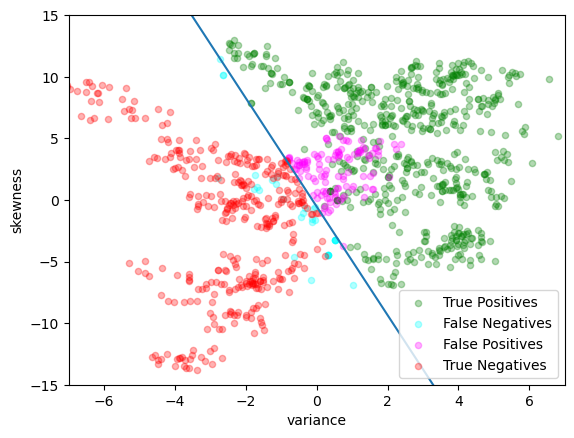

In [10]:
fig, ax = plt.subplots()
xlim = (-7, 7)
ylim = (-15, 15)

x = np.linspace(-7, 7)
y = (-svm_v1.w["variance"]*x - svm_v1.b)/svm_v1.w["skewness"]

y_pred = svm_v1.predict(X_train)

kwargs = {"x": "variance", "y": "skewness", "kind": "scatter", "ax": ax, "xlim": xlim, "ylim": ylim}

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X_train[(y_pred > 0) * (y_train > 0)].plot(**kwargs, c="g", alpha=0.3, label="True Positives")
    X_train[(y_pred < 0) * (y_train > 0)].plot(**kwargs, c="cyan", alpha=0.3, label="False Negatives")
    X_train[(y_pred > 0) * (y_train < 0)].plot(**kwargs, c="magenta", alpha=0.3, label="False Positives")
    X_train[(y_pred < 0) * (y_train < 0)].plot(**kwargs, c="r", alpha=0.3, label="True Negatives")
    ax.plot(x, y)


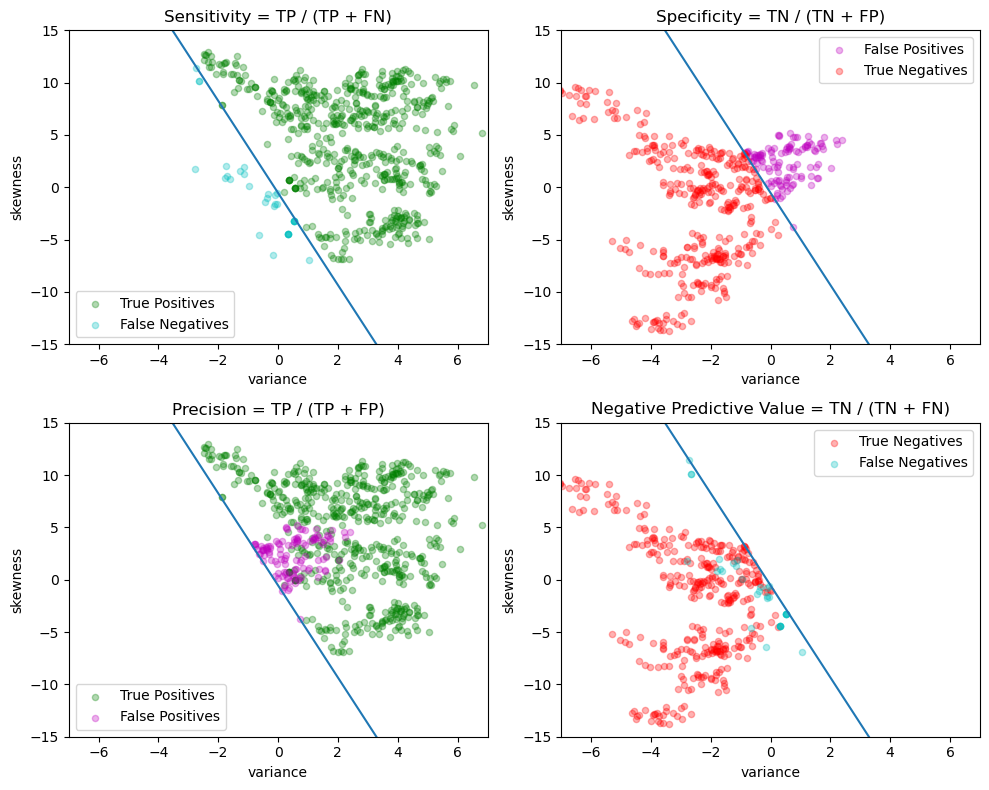

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
xlim = (-7, 7)
ylim = (-15, 15)

kwargs = {"x": "variance", "y": "skewness", "kind": "scatter", "alpha":0.3, "xlim": xlim, "ylim": ylim}

# catch and ignore a warning that may be a bug with matplotlib scatter plot
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X_train[(y_pred > 0) * (y_train > 0)].plot(**kwargs, ax=ax[0, 0], c="g", label="True Positives")
    X_train[(y_pred < 0) * (y_train > 0)].plot(**kwargs, ax=ax[0, 0], c="c", label="False Negatives")
    ax[0, 0].plot(x, y)
    ax[0, 0].set_title("Sensitivity = TP / (TP + FN)")
    
    X_train[(y_pred > 0) * (y_train < 0)].plot(**kwargs, ax=ax[0, 1], c="m", label="False Positives")
    X_train[(y_pred < 0) * (y_train < 0)].plot(**kwargs, ax=ax[0, 1], c="r", label="True Negatives")
    ax[0, 1].plot(x, y)
    ax[0, 1].set_title("Specificity = TN / (TN + FP)")
    
    X_train[(y_pred > 0) * (y_train > 0)].plot(**kwargs, ax=ax[1, 0], c="g", label="True Positives")
    X_train[(y_pred > 0) * (y_train < 0)].plot(**kwargs, ax=ax[1, 0], c="m", label="False Positives")
    ax[1, 0].plot(x, y)
    ax[1, 0].set_title("Precision = TP / (TP + FP)")
    
    X_train[(y_pred < 0) * (y_train < 0)].plot(**kwargs, ax=ax[1, 1], c="r", label="True Negatives")
    X_train[(y_pred < 0) * (y_train > 0)].plot(**kwargs, ax=ax[1, 1], c="c", label="False Negatives")
    ax[1, 1].plot(x, y)
    ax[1, 1].set_title("Negative Predictive Value = TN / (TN + FN)")
    
fig.tight_layout()

## Conic optimization model

### Primal formulation

The standard formulation of a linear support vector machine uses training sets with $p$-element feature vectors $x_i\in\mathbb{R}^p$ along with classification labels for those vectors, $y_i = \pm 1$. A classifier is defined by two parameters: a weight vector $w\in\mathbb{R}^p$ and a bias term $b\in\mathbb{R}$

$$
\begin{align*}
     y^{pred} & = \text{sgn}(w^\top x + b)
\end{align*}
$$

We train the classifier by developing and solving an optimization model for the values of $w$ and $b$. The presence of parameter $b$, however, unnecessarily complicates the presentation and derivation of the model. To simplify, we introduce an augmented feature vector $\bar{x} = (1, x) \in \mathbb{R}^{p+1}$ and an augmented weight vector $\bar{w} = (b, w) \in \mathbb{R}^{p+1}$ so the classifier can be presented as

$$
\begin{align*}
y^{pred} & = \text{sgn}(\bar{w}^\top \bar{x})
\end{align*}
$$

Given a value of $\bar{w}$, there is a family of hyperplanes in $\mathbb{R}^{p+1}$ orthogonal to $\bar{w}$. A **separating hyperplane**, if one exists, separates all data points with $y_i = 1$ from those with $y_i = -1$. The distance between $\bar{x}_i$ and the separating  hyperplane is the length of the projection $\bar{x}_i$ onto $\bar{w}$, which is

$$\frac{\bar{w}^\top \bar{x}_i}{\|\bar{w}\|}$$

If a separating hyperplane exists, then we can choose the norm of $\bar{w}$ so that a hard-margin classifier exists for the training set $(\bar{x}_i, y_i)$ where

$$
\begin{align*}
y_i \bar{w}^\top \bar{x}_i & \geq 1 & \forall i \in 1, 2, \dots, n
\end{align*}
$$

Otherwise, if a separating hyperplane does not exist, we introduce non-negative slack variables $z_i$ to relax the constraints and settle for a soft-margin classifier 

$$
\begin{align*}
y_i \bar{w}^\top \bar{x}_i & \geq 1 - z_i& \forall i \in 1, 2, \dots, n
\end{align*}
$$ 

Given $\bar{w}$, training data for which $z_i > 1$ are misclassified. The training objective is to minimize the number and distance to misclassified data points. This leads to the optimization problem

$$
\begin{align*}
\min \frac{1}{2} \|\bar{w}\|_2^2 & + \frac{c}{n}\sum_{i=1}^n z_i \\
\text{s.t.} \qquad z_i & \geq 1 - y_i \bar{w}^\top \bar{x}_i & \forall i = 1, 2, \dots, n \\
z_i & \geq 0 & \forall i = 1, 2, \dots, n
\end{align*}
$$

where $\frac{1}{2} \|\bar{w}\|_2^2$ is included to regularize the solution for $\bar{w}$. Choosing larger values of $c$ will reduce the number and size of misclassifications. The trade-off will be larger weights $\bar{w}$ and the accompanying risk of over over-fitting the training data. 

To simplify the presentation of the model, we introduce an $n \times (p+1)$ matrix $F$ constructed from the training data

$$
\begin{align}
    F & = \begin{bmatrix} y_1\bar{x}_1^\top \\ y_2\bar{x}_2^\top \\ \vdots \\ y_n\bar{x}_n^\top \end{bmatrix}
\end{align}
$$

Next we introduce a **[rotated quadratic cone](https://docs.mosek.com/modeling-cookbook/cqo.html#equation-eq-sec-qo-modeling-qset2)** defined as 

$$\mathcal{Q}^m_r = \{u\in\mathbb{R}^m | 2u_1u_2 \geq u_3^2 + \cdots + u_m^2,\ u_1, u_2 \geq 0 \}$$

and parameter $r$ where 

$$2 r \geq \|\bar{w}\|_2^2 = \bar{w}_1^2 + \bar{w}_2^2 + \cdots + \bar{w}_{p+1}^2$$

With these additional components, the problem is now a conic optimization problem ready for implementation with the Pyomo [Kernel Library](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/index.html) and Mosek conic solver.

$$
\begin{align*}
    & \min\ r + \frac{c}{n} 1^\top z\\
    \text{s. t.}\qquad & (r, 1, \bar{w}) \in \mathcal{Q}_r^{3 + p} \\
    & z + F \bar{w} \geq 1  \\
    & z \geq 0 & z\in\mathbb{R}^n \\
    & r\in\mathbb{R} \\
\end{align*}
$$

Like for the previous case, the Pyomo implementation is a "factory" function that returns a linear SVM.

In [12]:
import pyomo.kernel as pmo

def conicSvmFactory(X, y, c=1):
    
    # create data matrix F
    n, p = X.shape
    F = np.array([y.iloc[i] * np.append(1, X.iloc[i, :].to_numpy()) for i in range(n)])
    
    # create model block
    m = pmo.block()

    # decision variables
    m.r = pmo.variable()
    m.w = pmo.variable_list([pmo.variable() for i in range(p+1)])
    m.z = pmo.variable_list([pmo.variable(lb=0) for i in range(n)])
    
    # objective
    m.primal = pmo.objective(expr = m.r + (c/n) * sum(m.z))
    
    # constraints
    m.qr = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.w)
    m.d = pmo.constraint_list([pmo.constraint(body=m.z[i] + sum(F[i, j]*m.w[j] for j in range(p+1)), lb=1) for i in range(n)])

    # solve
    pmo.SolverFactory('mosek_direct').solve(m)
    
    # return svm
    b = m.w[0]()
    w = pd.Series({k: m.w[j+1]() for j, k in enumerate(X.columns)})
    
    return LinearSvm(w, b)

svm_v2 = conicSvmFactory(X_train, y_train, c=10)
print(svm_v2.w)
print(svm_v2.b)

variance    0.560461
skewness    0.155860
dtype: float64
-0.17471697516544543


In [13]:
validate(y_test, svm_v2.predict(X_test))

Matthews correlation coefficient (MCC) = 0.789
Sensitivity =  90.2%
Precision =  89.6%
Accuracy =  89.5%


,Predicted Positive,Predicted Negative
Actual Positive,129,14
Actual Negative,15,117


0.7887122815235176

### Dual formulation

The dual formulation for the SVM provides important insight into how a linear SVM works, and is essential for extending SVM to nonlinear classification. The dual formulation begins by creating a differentiable Lagrangian with dual factors $\alpha_i \geq 0$ and $\beta_i \geq 0$ for $i = 1, \dots, n$, the task is to find saddle points of

$$
\begin{align*}
\mathcal{L} & = \frac{1}{2} \|\bar{w}\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i + \sum_{i=1}^n \alpha_i (1 - y_i \bar{w}^\top \bar{x}_i - z_i) + \sum_{i=1}^n \beta_i (-z_i) \\
\end{align*}
$$

Taking derivatives with respect to the primal variables

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_i} & = \frac{c}{n} - \alpha_i - \beta_i = 0 \implies 0 \leq \alpha_i \leq \frac{c}{n}\\
\frac{\partial \mathcal{L}}{\partial \bar{w}} & = \bar{w}  - \sum_{i=1}^n \alpha_i y_i \bar{x}_i = 0 \implies  \bar{w} = \sum_{i=1}^n \alpha_i y_i \bar{x}_i \\
\end{align*}
$$

This can be arranged in the form of a standard quadratic program in $n$ variables $\alpha_i$ for $i = 1, \dots, n$.

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( \bar{x}_i^\top \bar{x}_j ) -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

The symmetric $n \times n$ **Gram matrix** is defined as

$$
    G = \begin{bmatrix} 
        (y_1\bar{x}_1^\top)(y_1\bar{x}_1) & \dots & (y_1\bar{x}_1^\top)(y_n\bar{x}_n) \\ 
        \vdots & \ddots & \vdots \\ 
        (y_n\bar{x}_n^\top)(y_1\bar{x}_1) & \dots & (y_n\bar{x}_n^\top)(y_n\bar{x}_n)
    \end{bmatrix}
$$

where each entry is dot product of two vectors $(y_i\bar{x}_i), (y_j\bar{x}_j) \in \mathbb{R}^{p+1}$. 

Compared to the primal, the dual formulation appears to have reduced the number of decision variables from $n + p + 1$ to $n$. But this has come with the penalty of introducing a dense matrix with $n^2$ coefficients and potential processing time of order $n^3$. For large training sets where $n\sim 10^4-10^6$ or even larger, this becomes a prohibitively expensive calculation. In addition, the Gram matrix will be rank deficient for cases $p+1 < n$. 

Reformulating the dual problem as a conic program eliminates the need to compute and store the full Gram matrix $G$. The reformulation begins by use the $n \times (p+1)$ matrix $F$ previously introduced in the primal problem:

$$
    F = \begin{bmatrix} y_1 \bar{x}_1^\top \\ y_2 \bar{x}_2^\top \\ \vdots \\ y_n \bar{x}_n^\top \end{bmatrix}
$$

Then $G = FF^\top$ and the optimization problem becomes

$$
\begin{align*}
\min\ & \frac{1}{2} \alpha^\top F F^\top \alpha -  1^\top \alpha \\
\text{s. t.}\quad & 0 \leq \alpha \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

We introduce an additional decision variable $r \geq 0$ to specify rotated quadratic cones. Let $z = F^\top\alpha$, then

$$\alpha^\top F F^\top \alpha \leq 2 r \iff z^\top z \leq 2 r \iff (r, 1, z) \in Q_r^{3 + p}$$

The result is a conic program for the dual coefficients $\alpha$ and auxiliary variables $r$ and $z$.

$$
\begin{align*}
& \min\ r - 1^\top \alpha\\
\text{s. t.}\qquad & (r, 1, z) \in \mathcal{Q}_r^{3 + p} & r\in\mathbb{R} \\
& z = F^\top \alpha & z\in\mathbb{R}^{p+1} \\
& 0 \leq \alpha \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

The solution to dual formulation provides an alternative expression for the resulting support vector machine. Let ${SV}$ represent the set of **support vectors**, which can be implemented as the set of indices for which $\alpha_i > 0$. 
Then SVM can be expressed as either

$$
\begin{align}
y^{pred} & = \text{sgn}\left( \bar{w}^\top \bar{x} \right)\quad
\text{where}\quad \bar{w} = \sum_{i\in\cal{SV}} \alpha_i y_i \bar{x}_i 
\end{align}
$$

or, more directly, as

$$
\begin{align}
y^{pred} & =  \text{sgn}\left( \sum_{i\in\cal{SV}} \alpha_i y_i \bar{x}_i^\top \bar{x} \right)
\end{align}
$$

The first formulation is a computationally efficient implementation of a linear SVM, and used in the following Pyomo implementation. The second formulation, however, provides additional insight into how an SVM works, and is the basis for important generalizations of SVM including the kernelized SVM discussed below.

### Pyomo implementation

variance    0.560478
skewness    0.155889
dtype: float64 -0.17471579844120927
Matthews correlation coefficient (MCC) = 0.789
Sensitivity =  90.2%
Precision =  89.6%
Accuracy =  89.5%


,Predicted Positive,Predicted Negative
Actual Positive,129,14
Actual Negative,15,117


0.7887122815235176

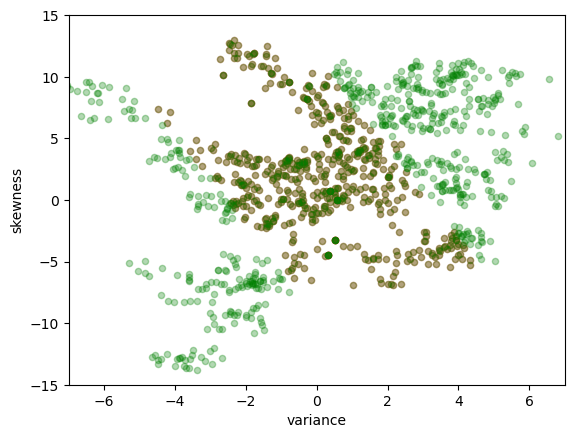

In [14]:
import pyomo.kernel as pmo

def conicDualSVMFactory(X, y, c=1):
    
    n, p = X.shape
    F = np.array([y.iloc[i]*np.append(1, X.iloc[i, :].to_numpy()) for i in range(n)])
    
    m = pmo.block()
    
    # decision variables
    m.r = pmo.variable()
    m.a = pmo.variable_list([pmo.variable(lb=0, ub=c/n) for i in range(n)])
    m.z = pmo.variable_list([pmo.variable() for i in range(n)])
    
    # objective
    m.o = pmo.objective(expr=m.r - sum(m.a))

    # constraints
    m.d = pmo.constraint_list([pmo.constraint(body=sum(F[i, j]*m.a[i] for i in range(n)) - m.z[j], rhs=0) for j in range(p + 1)]) 
    m.q = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.z)
    
    # solve
    pmo.SolverFactory('mosek_direct').solve(m)
    
    # get the support
    S = [i for i in range(n) if (m.a[i]() > 0)]
    
    # create and return linear SVM
    w_bar = sum(m.a[i]() * F[i, :] for i in S)
    w = pd.Series({k: w_bar[j+1] for j, k in enumerate(X.columns)})
    b = w_bar[0]
    
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        fig, ax = plt.subplots()
        X.iloc[S, :].plot(**kwargs, ax=ax, c='r')
        X.plot(**kwargs, ax=ax, c='g')

    return LinearSvm(w, b)

svm_v3 = conicDualSVMFactory(X_train, y_train, c=10)
print(svm_v3.w, svm_v3.b)
validate(y_test, svm_v3.predict(X_test))


## Kernelized SVM

### Nonlinear feature spaces

A linear SVM assumes the existence of a linear hyperplane that separates labeled sets of data points. Frequently, however, this is not possible and some sort of nonlinear method is needed. 

Consider a binary classification done given by a function

$$y^{pred} = \text{sgn} \left( \bar{w}^\top \phi(\bar{x}) \right)$$

where $\phi(\bar{x})$ is a function mapping $\bar{x}$ into a higher dimensional "feature space". That is, $\phi : \mathbb{R}^{p + 1} \rightarrow \mathbb{R}^d$ where $d > p + 1$. The additional dimensions may include features such as powers of the terms in $\bar{x}$, or products of those terms, or other types of nonlinear transformations. As before, we wish to find a choice for $\bar{w}\in\mathbb{R}^d$ such that the soft-margin classifier

$$
\begin{align}
y_i \bar{w}^\top \phi(\bar{x}_i & \geq 1 - z_i & i = 1, 2, \ldots, n
\end{align}
$$

Using the machinery as before, we set up the Lagrangian

$$
\begin{align*}
\mathcal{L} & = \frac{1}{2} \|\bar{w}\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i + \sum_{i=1}^n \alpha_i (1 - y_i \bar{w}^\top \phi(\bar{x}_i) - z_i) + \sum_{i=1}^n \beta_i (-z_i) \\
\end{align*}
$$

then take derivatives to find

$$
\begin{align*}
    \frac{\partial \mathcal{L}}{\partial z_i} & = \frac{c}{n} - \alpha_i - \beta_i = 0 \implies 0 \leq \alpha_i \leq \frac{c}{n}\\
    \frac{\partial \mathcal{L}}{\partial \bar{w}} & = \bar{w}  - \sum_{i=1}^n \alpha_i y_i \bar{x}_i = 0 \implies  \bar{w} = \sum_{i=1}^n \alpha_i y_i \phi(\bar{x}_i) \\
\end{align*}
$$

This similar to the case of a linear SVM, but in this case the vector of weights $\bar{w}\in\mathbb{R}^d$ which can be a very high dimensional space with nonlinear features. Work through the algebra, we are once again left with a quadratic program in $n$ variables $\alpha_i$ for $i = 1, \dots, n$.

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j  \phi(\bar{x}_i)^\top \phi(\bar{x}_j) -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

where the resulting classifier is given by 

$$y^{pred} = \text{sgn} \left( \sum_{i=1}^n \alpha_i \phi(\bar{x_i})^\top \phi(\bar{x}) \right)$$

### The kernel trick

This is an interesting situation where the separating hyperplane is embedded in a high dimensional space of nonlinear features determined by the mapping $\phi(\bar{x})$, but all we need for computation are the inner products  $\phi(\bar{x}_i)^\top\phi(\bar{x}_j)$ to train the classifier, and the inner products $\phi(\bar{x}_i)^\top\phi(\bar{x})$ to use the classifier. If we had a function $K(\bar{x}, \bar{z})$ that returned the value $\phi(\bar{x})^\top\phi(\bar{z})$ then we would never need to actually compute $\phi(\bar{x})$ or $\phi(\bar{z})$.

Mercer's theorem turns the analysis on its head by specifying conditions for which a function $K(\bar{x}, \bar{z})$ to be expressed as an inner product for some $\phi(bar{x})$. If $K(\bar{x}, \bar{z})$ is symmetric (i.e, $K(\bar{x}, \bar{z}) = K(\bar{z}, \bar{x})$, and if the Gram matrix constructed for any collection of points $\bar{x}_1, \bar{x}_2, \ldots, \bar{x}_n$ 

$$
\begin{bmatrix} 
    K(\bar{x}_1, \bar{x}_1) & \dots & K(\bar{x}_1, \bar{x}_n) \\ 
    \vdots & \ddots & \vdots \\ 
    K(\bar{x}_n, \bar{x}_1) & \dots & K(\bar{x}_n, \bar{x}_n) 
\end{bmatrix}
$$

is positive semi-definite, then there is some $\phi(\bar{x})$ for which $K(\bar{x}, \bar{z})$ is an inner product. We call such functions kernels. The practical consequence is that we can train and implement nonlinear classifiers using kernel and without ever needing to compute the higher dimensional features. This remarkable result is called the "kernel trick".

### Implementation

To take advantage of the kernel trick, we assume an appropriate kernel $K(\bar{x}, \bar{z})$ has been identified, then replace all instances of $\phi(\bar{x_i})^\top \phi(\bar{x})$ with the kernel. The "kernelized" SVM is then given by solution to 

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j K(\bar{x}_i, \bar{x}_j) -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

where the resulting classifier is given by 

$$y^{pred} = \text{sgn} \left( \sum_{i=1}^n \alpha_iK(\bar{x}_i, \bar{x}) \right)$$

We define the $n\times n$ positive symmetric semi-definite Gram matrix

$$
G = \begin{bmatrix} 
    y_1 y_1 K(\bar{x}_1, \bar{x}_1) & \dots & y_1 y_nK(\bar{x}_1, \bar{x}_n) \\ 
    \vdots & \ddots & \vdots \\ 
    y_n y_1 K(\bar{x}_n, \bar{x}_1) & \dots & y_n y_n K(\bar{x}_n, \bar{x}_n) 
\end{bmatrix}
$$

We factor $G = FF^\top$ where $F$ has dimensions $n \times k$ and $k$ is the rank of $G$. As demonstrated in the Python code below, one factorization is the spectral factorization $G = U\Lambda U^T$ where $\Lambda$ is a $k\times k$ diagonal matrix of non-zero eigenvalues, and $U$ is an $n\times k$ normal matrix such that $U^\top U = I_k$. Then

$$F = U\Lambda^{1/2}$$

Once this factorization is complete, the optimization problem for the kernalized SVM is the same as for the linear SVM in the dual formultion

$$
\begin{align*}
\min\ & \frac{1}{2} \alpha^\top F F^\top \alpha -  1^\top \alpha \\
\text{s. t.}\quad & 0 \leq \alpha \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

The result is a conic program for the dual coefficients $\alpha$ and auxiliary variables $r$ and $z$.

$$
\begin{align*}
& \min\ r - 1^\top \alpha\\
\text{s. t.}\qquad & (r, 1, z) \in \mathcal{Q}_r^{3 + p} & r\in\mathbb{R} \\
& z = F^\top \alpha & z\in\mathbb{R}^{p+1} \\
& 0 \leq \alpha \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

Summarizing, the essential difference between training the linear and kernelized SVM is the need to compute and factor the Gram matrix. The result will be a set of non-zero coefficients $\alpha_i > 0$ the define a set of support vectors $\mathcal{SV}$. The classifier is then given by

$$y^{pred} = \text{sgn} \left( \sum_{i\in\mathcal{SV}} \alpha_iK(\bar{x}_i, \bar{x}) \right)$$



In [15]:
import numpy as np
import pyomo.kernel as pmo

kernel = lambda x, z : np.exp(-0.5*np.linalg.norm(x - z)**2) # (1 + x @ z)**10

def kernelSVMFactory(X, y, c, tol=1e-8):
    
    n, p = X.shape
    
    # convert to numpy arrays for speed
    X_ = np.hstack([np.ones((n, 1)), X.to_numpy()])
    y_ = y.to_numpy()
    
    # kernel matrix
    G = [[y_[i] * y_[j] * kernel(X_[i, :], X_[j, :]) for j in range(n)] for i in range(n)]
    
    # spectral factors for a positive semi-definite matrix
    eigvals, V = np.linalg.eigh(G)
    idx = (eigvals >= tol * max(eigvals))
    F = V[:, idx] @ np.diag(np.sqrt(eigvals[idx]))

    # build model
    m = pmo.block()
    
    # decision variables
    m.r = pmo.variable()
    m.a = pmo.variable_list([pmo.variable(lb=0, ub=c/n) for i in range(n)])
    m.z = pmo.variable_list([pmo.variable() for i in range(n)])
    
    # objective
    m.o = pmo.objective(expr=m.r - sum(m.a))

    # constraints
    m.d = pmo.constraint_list([pmo.constraint(body=sum(F[i, j]*m.a[i] for i in range(n)) - m.z[j], rhs=0) for j in range(p + 1)]) 
    m.q = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.z)
    
    # solve
    pmo.SolverFactory('mosek_direct').solve(m)
    
    # get svm parameters
    SV = [i for i in range(n) if (m.a[i]() > 1e-3)]
    
    def kernelSVM(Z):
        nz, pz = Z.shape
        Z_ = np.hstack([np.ones((nz, 1)), Z.to_numpy()])
        y_pred = pd.Series([np.sign(sum(m.a[i]() * y_[i] * kernel(X_[i, :], Z_[j, :]) for i in SV)) for j in range(nz)], index=Z.index)
        return y_pred

    return kernelSVM

svm = kernelSVMFactory(X_train, y_train, c=10)

In [19]:
validate(y_train, svm(X_train))

Matthews correlation coefficient (MCC) = 0.872
Sensitivity =  91.2%
Precision =  96.8%
Accuracy =  93.5%


,Predicted Positive,Predicted Negative
Actual Positive,550,53
Actual Negative,18,476


0.8718866880637597

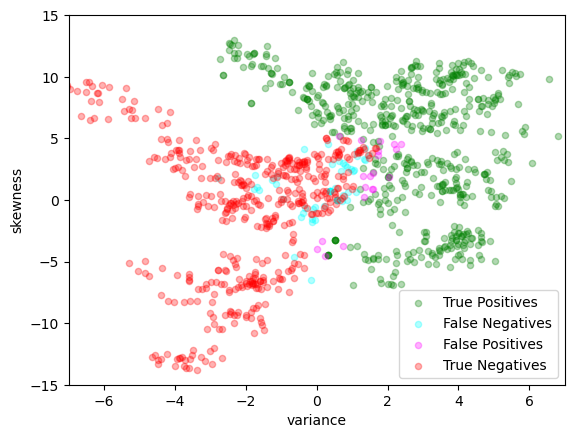

In [17]:
def vizsvm(X, y, y_pred):
    
    fig, ax = plt.subplots()
    kwargs = {"ax": ax, "x": "variance", "y": "skewness", "kind": "scatter", "alpha":0.3, "xlim": xlim, "ylim": ylim}

    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        X[(y_pred > 0) * (y > 0)].plot(**kwargs, c="g", label="True Positives")
        X[(y_pred < 0) * (y > 0)].plot(**kwargs, c="cyan", label="False Negatives")
        X[(y_pred > 0) * (y < 0)].plot(**kwargs, c="magenta", label="False Positives")
        X[(y_pred < 0) * (y < 0)].plot(**kwargs, c="r", label="True Negatives")
        
vizsvm(X_train, y_train, svm(X_train))


## Full Dataset

In [18]:
# create training and validation test sets
df_train, df_test = train_test_split(df, test_size=0.2)
print(df.columns)

# select training features
features = ["variance", "skewness"] #, "curtosis", "entropy"]

# separate into features and outputs
X_train = df_train[features]
y_train = 1 - 2 * df_train["class"]

# separate into features and outputs
X_test = df_test[features]
y_test = 1 - 2 * df_test["class"]

c = 1.0
svm = svm_conic_dual(X_train, y_train, c)
print(svm.w, svm.b)

validate(y_test, svm.predict(X_test))

Index(['variance', 'skewness', 'curtosis', 'entropy', 'class'], dtype='object')


NameError: name 'svm_conic_dual' is not defined

## Bibliographic Notes

The development of support vector machines is largely attributed to Vladimir Vapnik and colleagues at AT&T Bell Laboratories during the 1990's. The seminal papers are highly readable and entry points to the literature.

> Boser, B. E., Guyon, I. M., & Vapnik, V. N. (1992, July). A training algorithm for optimal margin classifiers. In Proceedings of the fifth annual workshop on Computational learning theory (pp. 144-152).  https://dl.acm.org/doi/10.1145/130385.130401

> Cortes, C., & Vapnik, V. (1995). Support-vector networks. Machine learning, 20(3), 273-297. https://link.springer.com/content/pdf/10.1007/bf00994018.pdf

Additional web resources are available at [Wikipedia](https://en.wikipedia.org/wiki/Kernel_method), [CMU](https://www.cs.cmu.edu/~aarti/Class/10315_Fall20/lecs/svm_dual_kernel.pdf), and [Oxford](https://www.robots.ox.ac.uk/~az/lectures/ml/lect3.pdf).

Support vector machines are a widely used method for supervised machine learning and described in tutorial blog postings and trade journal articles. Representative examples include 

> Sachin, D. N. (2020). Support Vector Machines with Amazon Food Reviews https://medium.com/analytics-vidhya/support-vector-machines-with-amazon-food-reviews-9fe0428e09ef

> http://www.adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-linear-svm/

